This is a port of the EM inference of LMM in [tensorflow/Probability](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Linear_Mixed_Effects_Models.ipynb)

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import theano

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

### Load data

In [2]:
url = ('https://raw.github.com/vincentarelbundock/Rdatasets/master/csv/'
         'lme4/InstEval.csv')
data = pd.read_csv(url)
data = data.drop(columns=['Unnamed: 0'])
data = data.rename(columns={'s': 'students',
                            'd': 'instructors',
                            'dept': 'departments',
                            'y': 'ratings'})
data['students'] -= 1  # start index by 0
# Remap categories to start from 0 and end at max(category).
data['instructors'] = data['instructors'].astype('category').cat.codes
data['departments'] = data['departments'].astype('category').cat.codes

train = data.sample(frac=0.8)
test = data.drop(train.index)

train.head()

,students,instructors,studage,lectage,service,departments,ratings
24670,998,697,2,2,0,4,5
52044,2087,918,8,4,1,2,4
31689,1290,405,4,1,0,4,3
58512,2365,390,2,4,0,2,3
11116,423,1093,6,2,1,1,5


Set up training and testing set

In [3]:
X_stud = theano.shared(train['students'].values)
X_inst = theano.shared(train['instructors'].values)
X_dept = theano.shared(train['departments'].values)
X_serv = theano.shared(train['service'].values)
Y_rate = theano.shared(train['ratings'].values)

In [4]:
X_serv.eval()

array([0, 1, 0, ..., 1, 1, 0])

In [5]:
num_students = max(data['students']) + 1
num_instructors = max(data['instructors']) + 1
num_departments = max(data['departments']) + 1
num_observations = train.shape[0]

print('Number of students:', num_students)
print('Number of instructors:', num_instructors)
print('Number of departments:', num_departments)
print('Number of observations:', num_observations)

Number of students: 2972
Number of instructors: 1128
Number of departments: 14
Number of observations: 58737


### Reference inference with NUTS
Priors are chosen so that it is weakly informative but still similar to the tfp model.

In [6]:
with pm.Model() as lmm_mcmc:
    # Set up fixed effects and other parameters.
    intercept = pm.Normal('intercept', 0., 100.)  # alpha in eq
    effect_service = pm.Normal('effect_service', 0., 100.)  # beta in eq
    stddev_students = pm.Exponential(
        'stddev_unconstrained_students', 1.)  # sigma in eq
    stddev_instructors = pm.Exponential(
        'stddev_unconstrained_instructors', 1.)  # sigma in eq
    stddev_departments = pm.Exponential(
        'stddev_unconstrained_departments', 1.)  # sigma in eq

    # Set up random effects
    effect_students = pm.Normal('effect_students', 0., tt.exp(
        stddev_students), shape=num_students)
    effect_instructors = pm.Normal('effect_instructors', 0., tt.exp(
        stddev_instructors), shape=num_instructors)
    effect_departments = pm.Normal('effect_departments', 0., tt.exp(
        stddev_departments), shape=num_departments)

    ratings = pm.Normal('ratings',
                        mu=(effect_service * X_serv +
                            effect_students[X_stud] +
                            effect_instructors[X_inst] +
                            effect_departments[X_dept] +
                            intercept),
                        sd=1.,
                        observed=Y_rate
                        )
    trace_nuts = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [effect_departments, effect_instructors, effect_students, stddev_unconstrained_departments, stddev_unconstrained_instructors, stddev_unconstrained_students, effect_service, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2335 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/junpenglao/miniconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


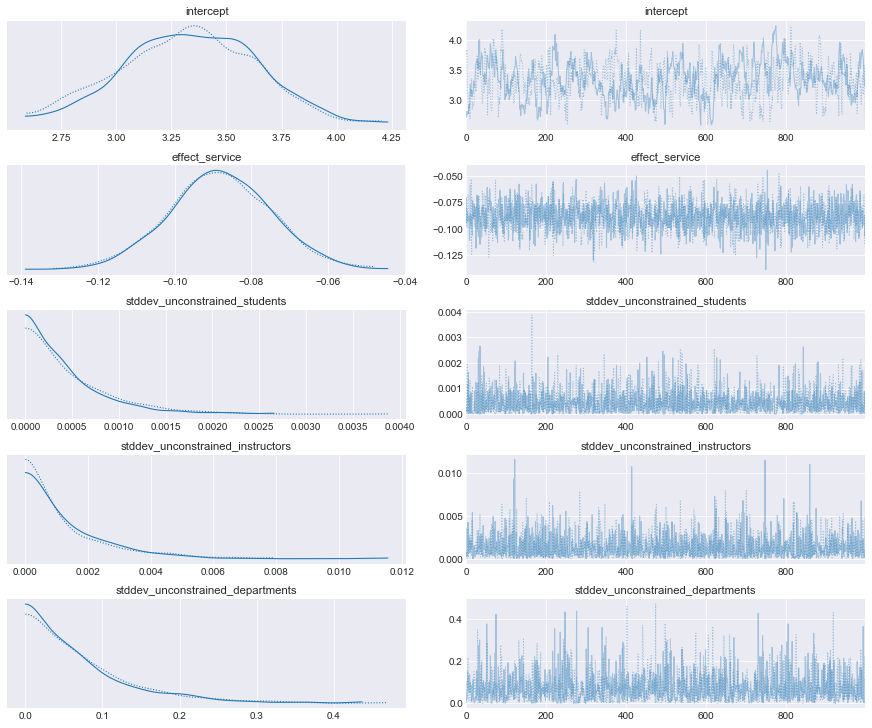

In [29]:
pm.traceplot(trace_nuts, 
             var_names=['intercept', 'effect_service', 
                        'stddev_unconstrained_students', 
                        'stddev_unconstrained_instructors',
                        'stddev_unconstrained_departments']);

### Inference with EM

Set up model in PyMC3 that is similar to the tfp one

In [8]:
with pm.Model() as lmm:
    # Set up fixed effects and other parameters.
    intercept = pm.Flat('intercept')  # alpha in eq
    effect_service = pm.Flat('effect_service')  # beta in eq
    stddev_students = pm.Flat(
        'stddev_unconstrained_students')  # sigma in eq
    stddev_instructors = pm.Flat(
        'stddev_unconstrained_instructors')  # sigma in eq
    stddev_departments = pm.Flat(
        'stddev_unconstrained_departments')  # sigma in eq

    # Set up random effects
    effect_students = pm.Normal('effect_students', 0., tt.exp(
        stddev_students), shape=num_students)
    effect_instructors = pm.Normal('effect_instructors', 0., tt.exp(
        stddev_instructors), shape=num_instructors)
    effect_departments = pm.Normal('effect_departments', 0., tt.exp(
        stddev_departments), shape=num_departments)

    ratings = pm.Normal('ratings',
                        mu=(effect_service * X_serv +
                            effect_students[X_stud] +
                            effect_instructors[X_inst] +
                            effect_departments[X_dept] +
                            intercept),
                        sd=1.,
                        observed=Y_rate
                        )

Gibbs sampling is one version of generalization of Expectation maximization. We can do some compound step magic to do EM in PyMC3

In [9]:
lmm.free_RVs

[intercept,
 effect_service,
 stddev_unconstrained_students,
 stddev_unconstrained_instructors,
 stddev_unconstrained_departments,
 effect_students,
 effect_instructors,
 effect_departments]

Parameters that we are going to maximize

In [10]:
lmm.free_RVs[0:5]

[intercept,
 effect_service,
 stddev_unconstrained_students,
 stddev_unconstrained_instructors,
 stddev_unconstrained_departments]

Parameters that we are going to take expectation.

In [11]:
lmm.free_RVs[5:]

[effect_students, effect_instructors, effect_departments]

Get conditional logp_dlogp function, test maximization

In [12]:
grad_vars = lmm.free_RVs[:5]
logp_dlogp_func = lmm.logp_dlogp_function(grad_vars)

In [13]:
point = lmm.test_point
point

{'intercept': array(0.),
 'effect_service': array(0.),
 'stddev_unconstrained_students': array(0.),
 'stddev_unconstrained_instructors': array(0.),
 'stddev_unconstrained_departments': array(0.),
 'effect_students': array([0., 0., 0., ..., 0., 0., 0.]),
 'effect_instructors': array([0., 0., 0., ..., 0., 0., 0.]),
 'effect_departments': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [14]:
logp_dlogp_func.set_extra_values(point)
array = logp_dlogp_func.dict_to_array(point)
array

array([0., 0., 0., 0., 0.])

In [15]:
logp_dlogp_func.get_extra_values()

{'effect_students': array([0., 0., 0., ..., 0., 0., 0.]),
 'effect_instructors': array([0., 0., 0., ..., 0., 0., 0.]),
 'effect_departments': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [16]:
logp_dlogp_func(array)

(array(-411471.7057508),
 array([ 1.88225e+05,  7.97830e+04, -2.97200e+03, -1.12800e+03,
        -1.40000e+01]))

In [17]:
logp_dlogp_func._cost_joined

__logp

In [18]:
logp_dlogp_func._vars_joined.tag.test_value

array([0., 0., 0., 0., 0.])

In [19]:
optimizer = pm.adam(learning_rate=0.01)

In [20]:
inputs = theano.shared(array, 'to_max')
cost_replace = theano.clone(-logp_dlogp_func._cost_joined,
                            {logp_dlogp_func._vars_joined: inputs})
updates = optimizer(cost_replace, [inputs])

In [21]:
logp_dlogp_func._vars_joined.tag.test_value

array([0., 0., 0., 0., 0.])

In [22]:
updates[inputs].tag.test_value

array([ 0.01,  0.01, -0.01, -0.01, -0.01])

In [23]:
extra_rvs = lmm.free_RVs[5:]
train = theano.function(
    inputs=extra_rvs,
    outputs=[cost_replace],
    updates=optimizer(cost_replace, [inputs]))

In [24]:
extra_point = logp_dlogp_func.get_extra_values()
input_array = [extra_point[var.name] for var in extra_rvs]
input_array

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

In [25]:
train(*input_array)

[array(411471.7057508)]

In [26]:
logp_dlogp_func.array_to_full_dict(inputs.eval())

{'intercept': array(0.01),
 'effect_service': array(0.01),
 'stddev_unconstrained_students': array(-0.01),
 'stddev_unconstrained_instructors': array(-0.01),
 'stddev_unconstrained_departments': array(-0.01),
 'effect_students': array([0., 0., 0., ..., 0., 0., 0.]),
 'effect_instructors': array([0., 0., 0., ..., 0., 0., 0.]),
 'effect_departments': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

Set up maximization

In [27]:
from pymc3.step_methods.arraystep import BlockedStep
from pymc3.model import modelcontext


class MaxFunc(BlockedStep):
    """
    Step method that take the maximization of RVs

    Parameters
    ----------
    vars : list
        List of variables to take maximization.
    optimizer: Theano function
        A Theano function that updates update dictionaries for training
        see pymc3.variational.updates
    model: pymc3 model
    tune : bool
        Flag for tuning. In the tuning optimaization is turn off. 
        Defaults to True.
    """

    def __init__(self, vars, optimizer=pm.adam(learning_rate=0.01), model=None, tune=True):
        model = modelcontext(model)

        self.generates_stats = True
        self.stats_dtypes = [{
            'loss': np.float64,
        }]

        self.vars = vars
        self.m = model
        self.tune = tune

        varnames = [var.name for var in vars]
        extra_vars = [
            var for var in model.free_RVs if var.name not in varnames
        ]
        self.extra_vars = extra_vars
        self._logp_dlogp_func = model.logp_dlogp_function(self.vars)

        point = model.test_point
        self._logp_dlogp_func.set_extra_values(point)
        np_array = self._logp_dlogp_func.dict_to_array(point)

        # TODO: accept scipy optimizer to directly optimize
        # self._logp_dlogp_func(np_array) in numpy
        self.shared_inputs = theano.shared(np_array, 'to_max')
        cost_replace = theano.clone(-self._logp_dlogp_func._cost_joined,
                                    {self._logp_dlogp_func._vars_joined: self.shared_inputs})

        self.train_fn = theano.function(
            inputs=extra_vars,
            outputs=[cost_replace],
            updates=optimizer(cost_replace, [self.shared_inputs]))

    def step(self, point):
        if self.tune:
            # No training happens in the tuning stage
            # It is roughly corresponding to the warm-up stage in the tfp example
            stats = {
                'loss': np.nan,
            }
        else:
            input_array = [point[var.name] for var in self.extra_vars]
            [loss] = self.train_fn(*input_array)
            self._logp_dlogp_func.set_extra_values(point)
            point = self._logp_dlogp_func.array_to_full_dict(self.shared_inputs.eval())
            stats = {
                'loss': loss,
            }
        return point, [stats]

In [32]:
# you might need to rerun this cell a couple times as the 
# warmup step could be a bit funky (zero gradient error)
with lmm:
    step1 = pm.HamiltonianMC(vars=lmm.free_RVs[5:])
    step2 = MaxFunc(vars=lmm.free_RVs[:5])
    trace = pm.sample(1000, tune=100, chains=1, 
                      step=[step2, step1],
                      discard_tuned_samples=False)

Sequential sampling (1 chains in 1 job)
CompoundStep
>MaxFunc: [intercept, effect_service, stddev_unconstrained_students, stddev_unconstrained_instructors, stddev_unconstrained_departments]
>HamiltonianMC: [effect_departments, effect_instructors, effect_students]


Sampling 1 chain for 100 tune and 1_000 draw iterations (100 + 1_000 draws total) took 164 seconds.
There were 316 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7636999904612352, but should be close to 0.65. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


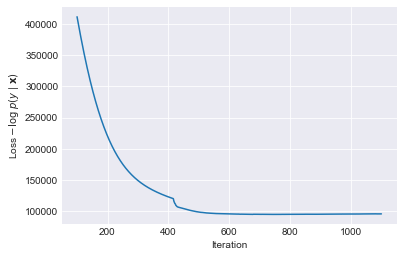

In [34]:
plt.plot(trace['loss'])
plt.ylabel(r'Loss $-\log$ $p(y\mid\mathbf{x})$')
plt.xlabel('Iteration');
# plt.ylim([95500, 100000]);

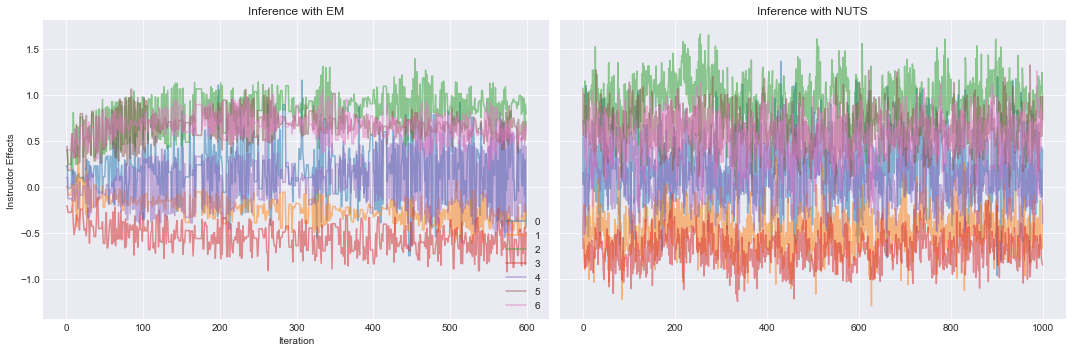

In [37]:
lb = 'effect_instructors'

_, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
for i in range(7):
    ax[0].plot(trace[lb][500:, i], alpha=.5)
    ax[1].plot(trace_nuts[lb][1000:, i], alpha=.5)

ax[0].set_title('Inference with EM')
ax[1].set_title('Inference with NUTS')
ax[0].legend([i for i in range(7)], loc='lower right')
ax[0].set_ylabel('Instructor Effects')
ax[0].set_xlabel('Iteration')
plt.tight_layout();

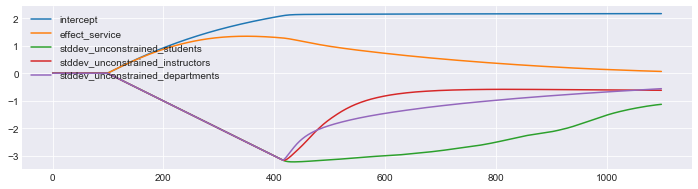

In [38]:
varnames=['intercept', 'effect_service',
          'stddev_unconstrained_students',
          'stddev_unconstrained_instructors',
          'stddev_unconstrained_departments']
_, ax = plt.subplots(1, 1, figsize=(12, 3))
for var in varnames:
    ax.plot(trace[var], label=var)
plt.legend(loc=2);

### Criticism

In [42]:
for vars in lmm.free_RVs[5:]:
    endpoint[vars.name] = trace[vars.name][700:].mean(axis=0)
endpoint

{'intercept': 2.168341888505965,
 'effect_service': 0.06422788994869018,
 'stddev_unconstrained_students': 0.3222255059123442,
 'stddev_unconstrained_instructors': 0.5371417301971558,
 'stddev_unconstrained_departments': 0.5692889344863775,
 'effect_students': array([0.10781602, 0.00274281, 0.08672836, ..., 0.09884653, 0.02937328,
        0.21226335]),
 'effect_instructors': array([ 0.19230466, -0.28506754,  0.87183966, ..., -0.34026806,
         0.70239725, -0.34995175]),
 'effect_departments': array([0.962203  , 0.82133   , 1.01042209, 1.1036459 , 1.12381008,
        0.8833976 , 1.03245646, 0.95028919, 0.94202131, 0.90518111,
        0.71620329, 1.04267516, 0.9364129 , 1.04756146])}

In [43]:
X_stud_test = test['students'].values
X_inst_test = test['instructors'].values
X_dept_test = test['departments'].values
X_serv_test = test['service'].values
labels_test = test['ratings'].values

ratings_pred = (endpoint['effect_service'] * X_serv_test +
                endpoint['effect_students'][X_stud_test] +
                endpoint['effect_instructors'][X_inst_test] +
                endpoint['effect_departments'][X_dept_test] +
                endpoint['intercept'])

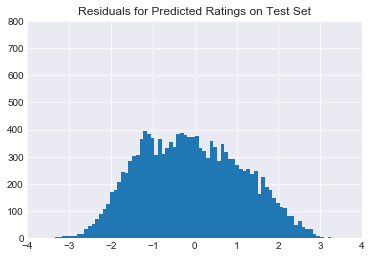

In [44]:
plt.title("Residuals for Predicted Ratings on Test Set")
plt.xlim(-4, 4)
plt.ylim(0, 800)
plt.hist(ratings_pred - labels_test, 75);

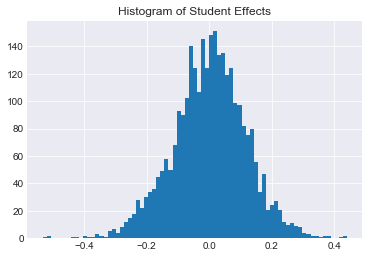

In [45]:
plt.title("Histogram of Student Effects")
plt.hist(endpoint['effect_students'], 75);

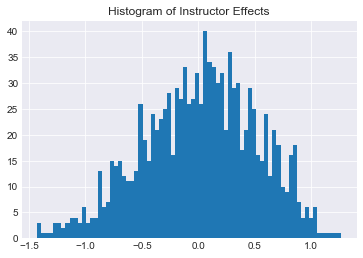

In [46]:
plt.title("Histogram of Instructor Effects")
plt.hist(endpoint['effect_instructors'], 75);

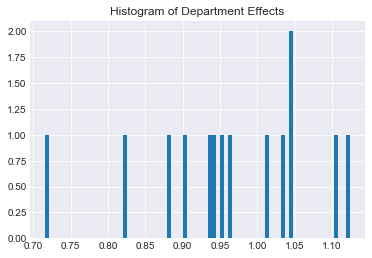

In [47]:
plt.title("Histogram of Department Effects")
plt.hist(endpoint['effect_departments'], 75);

### Bonus Information

We can easiest apply this inference on the original model.

In [49]:
# you might need to rerun this cell a couple times as the 
# warmup step could be a bit funky (zero gradient error)
with lmm_mcmc:
    step1 = pm.HamiltonianMC(vars=lmm_mcmc.free_RVs[5:])
    step2 = MaxFunc(vars=lmm_mcmc.free_RVs[:5])
    trace2 = pm.sample(1000, tune=100, chains=1, 
                      step=[step2, step1],
                      discard_tuned_samples=False)

/home/junpenglao/miniconda3/lib/python3.7/site-packages/pymc3/sampling.py:440: UserWarning: Tuning samples will be included in the returned `MultiTrace` object, which can lead to complications in your downstream analysis. Please consider to switch to `InferenceData`:
`pm.sample(..., return_inferencedata=True)`
  UserWarning
Sequential sampling (1 chains in 1 job)
CompoundStep
>MaxFunc: [intercept, effect_service, stddev_unconstrained_students, stddev_unconstrained_instructors, stddev_unconstrained_departments]
>HamiltonianMC: [effect_departments, effect_instructors, effect_students]


Sampling 1 chain for 100 tune and 1_000 draw iterations (100 + 1_000 draws total) took 164 seconds.
There were 297 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8229604292518213, but should be close to 0.65. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


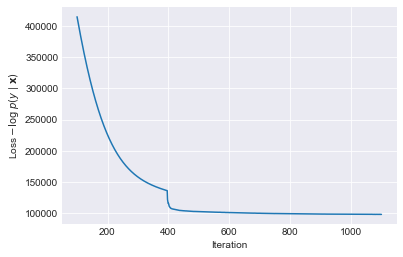

In [50]:
plt.plot(trace2['loss'])
plt.ylabel(r'Loss $-\log$ $p(y\mid\mathbf{x})$')
plt.xlabel('Iteration');

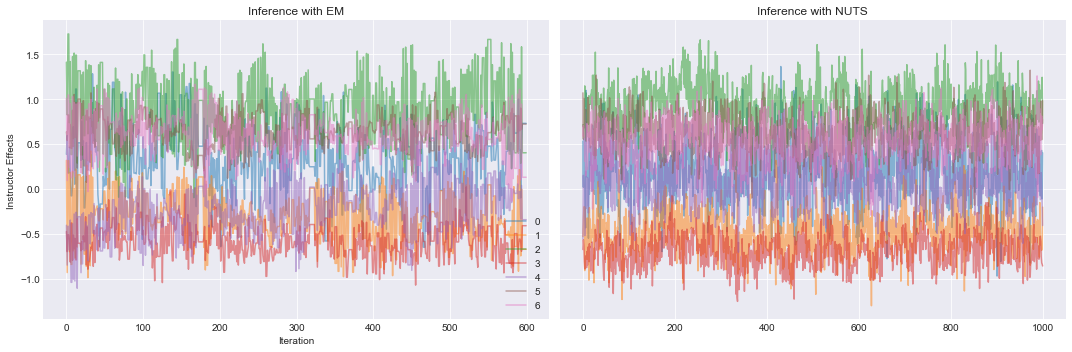

In [52]:
lb = 'effect_instructors'

_, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
for i in range(7):
    ax[0].plot(trace2[lb][500:, i], alpha=.5)
    ax[1].plot(trace_nuts[lb][1000:, i], alpha=.5)

ax[0].set_title('Inference with EM')
ax[1].set_title('Inference with NUTS')
ax[0].legend([i for i in range(7)], loc='lower right')
ax[0].set_ylabel('Instructor Effects')
ax[0].set_xlabel('Iteration')
plt.tight_layout();

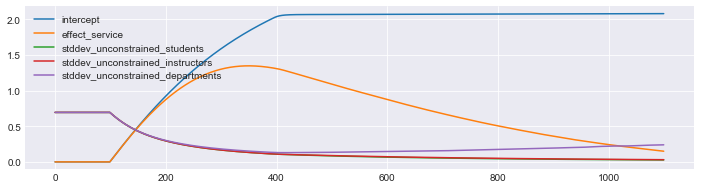

In [53]:
varnames=['intercept', 'effect_service',
          'stddev_unconstrained_students',
          'stddev_unconstrained_instructors',
          'stddev_unconstrained_departments']
_, ax = plt.subplots(1, 1, figsize=(12, 3))
for var in varnames:
    ax.plot(trace2[var], label=var)
plt.legend(loc=2);

In [54]:
endpoint2 = trace2[-1]
for vars in lmm.free_RVs[5:]:
    endpoint2[vars.name] = trace2[vars.name][700:].mean(axis=0)

In [55]:
nuts_mean = trace_nuts[-1]
for varname in trace_nuts.varnames:
    nuts_mean[varname] = trace_nuts[varname].mean(axis=0)

In [56]:
ratings_pred2 = (endpoint2['effect_service'] * X_serv_test +
                 endpoint2['effect_students'][X_stud_test] +
                 endpoint2['effect_instructors'][X_inst_test] +
                 endpoint2['effect_departments'][X_dept_test] +
                 endpoint2['intercept'])

ratings_pred_nuts = (nuts_mean['effect_service'] * X_serv_test +
                     nuts_mean['effect_students'][X_stud_test] +
                     nuts_mean['effect_instructors'][X_inst_test] +
                     nuts_mean['effect_departments'][X_dept_test] +
                     nuts_mean['intercept'])

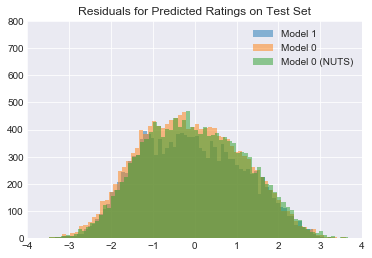

In [57]:
plt.title("Residuals for Predicted Ratings on Test Set")
plt.xlim(-4, 4)
plt.ylim(0, 800)
plt.hist(ratings_pred - labels_test, 75, alpha=.5, label='Model 1')
plt.hist(ratings_pred2 - labels_test, 75, alpha=.5, label='Model 0')
plt.hist(ratings_pred_nuts - labels_test, 75, alpha=.5, label='Model 0 (NUTS)')
plt.legend();

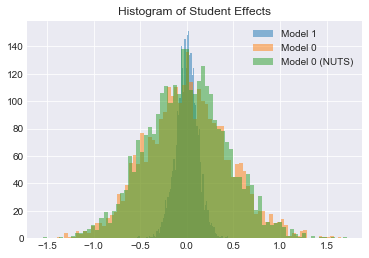

In [58]:
plt.title("Histogram of Student Effects")
plt.hist(endpoint['effect_students'], 75, alpha=.5, label='Model 1')
plt.hist(endpoint2['effect_students'], 75, alpha=.5, label='Model 0')
plt.hist(nuts_mean['effect_students'], 75, alpha=.5, label='Model 0 (NUTS)')
plt.legend();

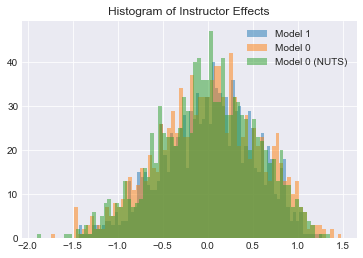

In [59]:
plt.title("Histogram of Instructor Effects")
plt.hist(endpoint['effect_instructors'], 75, alpha=.5, label='Model 1')
plt.hist(endpoint2['effect_instructors'], 75, alpha=.5, label='Model 0')
plt.hist(nuts_mean['effect_instructors'], 75, alpha=.5, label='Model 0 (NUTS)')
plt.legend();

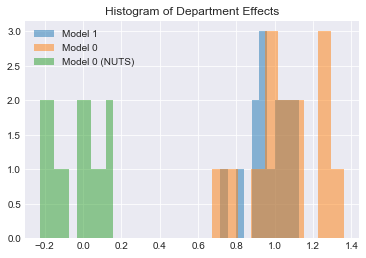

In [60]:
plt.title("Histogram of Department Effects")
plt.hist(endpoint['effect_departments'], alpha=.5, label='Model 1')
plt.hist(endpoint2['effect_departments'], alpha=.5, label='Model 0')
plt.hist(nuts_mean['effect_departments'], alpha=.5, label='Model 0 (NUTS)')
plt.legend();

### Afterthoughts

You might notice that the estimation via maximization are quite different compared to the posterior samples. In another word, the expectation is not the same as the maximization. However, if you are only looking at predictions as metrics to evaluate model performance, they often give quite similar predictions. A visual demonstration could be found [here](https://nbviewer.jupyter.org/github/junpenglao/GLMM-in-Python/blob/master/GLMM_in_python.ipynb#Display-estimation). Basically, the differences in the intercept is offset by the random effect.

Previously, I am also working on a similar notebook that approximate part of the RVs in a PyMC3 model with a [Laplace approximation](https://nbviewer.jupyter.org/github/junpenglao/Planet_Sakaar_Data_Science/blob/master/WIP/%5BWIP%5D%20Laplace%20approximation%20in%20pymc3.ipynb). I think these are good examples of how to extend the compound step in sampling to a more general compound inference API. One idea would be approximate some nodes with VI group approximation, or a trainable neural network that we already shown in AEVB. 